In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Content:
### Data Exploration
### Model 1: csho Imputation + no winsorization
### Model 2: csho Imputation + 1/99th percentile winsorization
### Model 3: csho Filtering + no winsorization
### Model 4: csho Filtering + 1/99th percentile winsorizatoin
### Model 5: shrout + no winsorization

## Data Exploration

In [48]:
filepath = "Prepared Data/prelim_fundamental_dataset.csv"
df = pd.read_csv(filepath)
df = df[['gvkey', 'jdate', 'ib', 'spi', 'E', 'csho', 'Shrout_at_Pricet', 'Pricet', 'at']]

/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_94050/1526648518.py:2: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [49]:
df.describe()

,gvkey,ib,spi,E,csho,Shrout_at_Pricet,Pricet,at
count,151025.000000,151025.000000,151025.000000,151025.000000,151025.000000,151025.000000,151025.000000,151025.000000
mean,28495.602702,89.690230,-18.856291,108.546521,56.850920,56.240971,28.585596,1959.461495
std,44448.134710,889.507166,354.661930,879.696358,282.792509,282.009653,779.362001,13639.466888
min,1000.000000,-56121.900000,-51066.200000,-39656.000000,0.000000,0.108000,1.001500,0.000000
25%,5567.000000,-0.407000,-0.815000,0.075000,3.836000,3.872000,5.375000,35.734000
50%,10152.000000,3.403000,0.000000,4.168000,11.218000,11.288000,12.875000,135.568000
75%,25522.000000,25.014000,0.000000,29.076000,33.895000,33.900000,26.670000,642.061000
max,315318.000000,59531.000000,22970.000000,59295.000000,10862.000000,10804.353000,133400.000000,797769.000000


In [50]:
# Report the percentiles of E, csho, pricet, and at
percentiles = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]
percentiles_df = df[['E', 'ib', 'spi', 'csho', 'Pricet', 'at']].quantile(percentiles)
print(percentiles_df)

               E          ib        spi       csho    Pricet           at
0.010  -150.8680  -272.76304 -409.45904    0.56600    1.1700      2.88724
0.025   -60.5368   -99.32140 -142.37600    0.79700    1.3750      4.66860
0.050   -27.4220   -43.35800  -54.00000    1.08400    1.7500      7.28120
0.100    -9.1570   -14.99300  -15.55160    1.61900    2.5000     12.75140
0.150    -3.2470    -5.91780   -6.00000    2.26500    3.3750     19.05220
0.200    -0.9000    -2.09240   -2.40000    2.98200    4.2500     26.54600
0.250     0.0750    -0.40700   -0.81500    3.83600    5.3750     35.73400
0.500     4.1680     3.40300    0.00000   11.21800   12.8750    135.56800
0.750    29.0760    25.01400    0.00000   33.89500   26.6700    642.06100
0.800    45.4900    39.74260    0.00000   44.33440   31.1250    953.99400
0.850    75.9656    66.22300    0.00000   59.85540   37.0000   1532.95320
0.900   144.1290   126.30740    0.12600   91.25880   45.7200   2655.78920
0.950   364.6418   324.03920    2.4138

In [51]:
zero_csho = df[df['csho'] == 0]
print("Rows with csho == 0:", len(zero_csho))
zero_shrout = df[df['Shrout_at_Pricet'] == 0]
print("Rows with Shrout_at_Pricet == 0:", len(zero_shrout))

Rows with csho == 0: 65
Rows with Shrout_at_Pricet == 0: 0


# Important Decision: Filter out csho = 0 or impute it? Use shrout instead?

In [52]:
# Calculate Market Capitalization
df['mkt_cap'] = df['csho'] * (df['Pricet'])
# find the percentiles of mkt_cap
mkt_cap_percentiles = df['mkt_cap'].quantile(percentiles)
print(mkt_cap_percentiles)
# Report max and min of mkt_cap
print("Max mkt_cap:", df['mkt_cap'].max())
print("Min mkt_cap:", df['mkt_cap'].min())

0.010        2.103228
0.025        3.432000
0.050        5.312600
0.100        9.376000
0.150       14.145965
0.200       20.146400
0.250       27.968000
0.500      120.428750
0.750      627.177600
0.800      935.111162
0.850     1500.150628
0.900     2749.434160
0.950     6853.949600
0.975    15317.231500
0.990    38963.437138
Name: mkt_cap, dtype: float64
Max mkt_cap: 905425.38
Min mkt_cap: 0.0


Restrict sample

In [53]:
# Restrict the time to 1975 and later
df['jdate'] = pd.to_datetime(df['jdate'])
df = df[df['jdate'] >= pd.Timestamp('1975-01-01')]

## RW Model

### Forecast errors deflated by market capitalization
Winsorization of deflators is applied at the 1% (lower) and 99% (upper) levels by default.

In [54]:
def winsorize_series(s, lower=0.01, upper=0.99):
    """Winsorize a pandas Series at the given lower/upper quantiles."""
    lower_bound = s.quantile(lower)
    upper_bound = s.quantile(upper)
    return s.clip(lower=lower_bound, upper=upper_bound)

# 1. Impute zero market cap with small constant, no winsorization on market cap

In [55]:
# Create a new column for the future earnings
df['E_future'] = df.groupby('gvkey')['E'].shift(-1)

# Replace zero market capitalizations with a small constant
df['mkt_cap'] = df['mkt_cap'].replace(0, 1e-3)

# Clipping out extreme values
df['mkt_cap_winsorized'] = winsorize_series(df['mkt_cap'])

# Forecast error: future earnings minus the current earnings divided by the market capitalization 
df['forecast_error'] = (df['E_future'] - df['E']) / df['mkt_cap']

# Absolute errors
df['absolute_forecast_error'] = df['forecast_error'].abs()
df['absolute_forecast_error'].describe()

count    126717.000000
mean          4.840005
std         293.574884
min           0.000000
25%           0.011495
50%           0.029531
75%           0.077289
max       41952.000000
Name: absolute_forecast_error, dtype: float64

In [56]:
# 1. Mean Absolute Forecast Error (MAFE)
mafe = df['absolute_forecast_error'].mean()
print(f"Mean Absolute Forecast Error (MAFE): {mafe}")
print(f"Expected: 0.0764")

# 2. Median Absolute Forecast Error
median_afe = df['absolute_forecast_error'].median()
print(f"Median Absolute Forecast Error: {median_afe}")
print(f"Expected: 0.0309")

Mean Absolute Forecast Error (MAFE): 4.84000525953187
Expected: 0.0764
Median Absolute Forecast Error: 0.02953107993941562
Expected: 0.0309


In [57]:
# Top 10 largest forecast errors
top_10_errors = df.nlargest(10, 'absolute_forecast_error')
top_10_errors

,gvkey,jdate,ib,spi,E,csho,Shrout_at_Pricet,Pricet,at,mkt_cap,E_future,mkt_cap_winsorized,forecast_error,absolute_forecast_error
44425,8817,1983-03-31,72.878,0.000,72.878,0.000,0.720,118.00,871.268,0.00100,114.830,2.09143,41952.000000,41952.000000
105149,4611,1992-03-31,-208.596,-58.901,-149.695,0.001,79.200,14.25,6125.668,0.01425,443.964,2.09143,41660.280702,41660.280702
44427,8817,1985-03-31,93.986,0.000,93.986,0.000,0.720,118.00,905.201,0.00100,135.221,2.09143,41235.000000,41235.000000
44421,8817,1979-03-31,45.789,0.000,45.789,0.000,0.720,118.00,638.615,0.00100,69.635,2.09143,23846.000000,23846.000000
44424,8817,1982-03-31,49.411,0.000,49.411,0.000,0.720,118.00,834.521,0.00100,72.878,2.09143,23467.000000,23467.000000
44426,8817,1984-03-31,114.830,0.000,114.830,0.000,0.720,118.00,894.844,0.00100,93.986,2.09143,-20844.000000,20844.000000
90334,9470,1995-03-31,58.839,0.000,58.839,0.000,1.591,11.75,727.244,0.00100,41.443,2.09143,-17396.000000,17396.000000
54661,6530,1988-03-31,158.969,0.000,158.969,0.001,6.898,8.25,1091.616,0.00825,16.634,2.09143,-17252.727273,17252.727273
54664,6530,1991-03-31,-68.166,-25.000,-43.166,0.001,6.898,8.25,1175.560,0.00825,97.551,2.09143,17056.606061,17056.606061
44429,8817,1987-03-31,149.776,0.000,149.776,0.000,0.720,118.00,1019.138,0.00100,132.928,2.09143,-16848.000000,16848.000000


# It appears that MAFE is inflated because of the small imputed market cap values and other small market cap values!

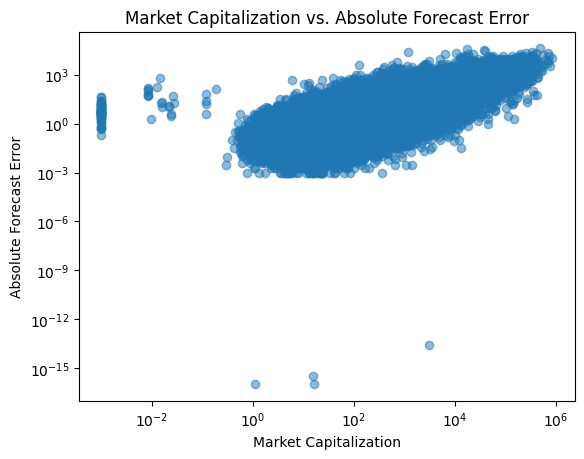

In [58]:
# plot market cap vs. absolute forecast error (no deflation)
plt.scatter(df['mkt_cap'], (df['E_future'] - df['E']).abs(), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Market Capitalization')
plt.ylabel('Absolute Forecast Error')
plt.title('Market Capitalization vs. Absolute Forecast Error')
plt.show()

# As expected, deflators should correct for size

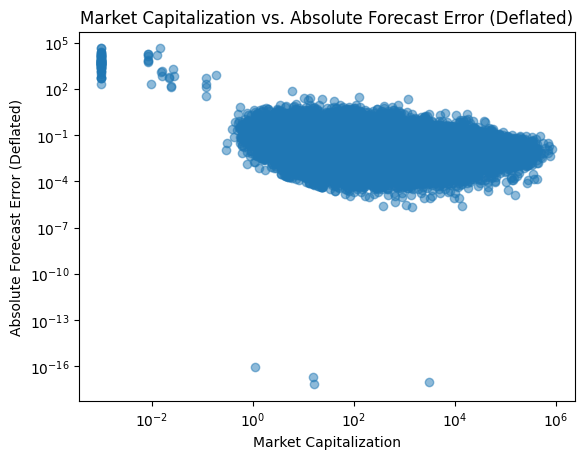

In [59]:
# plot market cap vs. absolute forecast error
plt.scatter(df['mkt_cap'], df['absolute_forecast_error'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Market Capitalization')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Market Capitalization vs. Absolute Forecast Error (Deflated)')
plt.show()

## One approach would be to capture the main cluster; the rest can be considered as outliers. You can clearly see how the imputed values affect the results in this plot

# Special Items (spi) seem fine for the most part. Recall that E = ib - spi

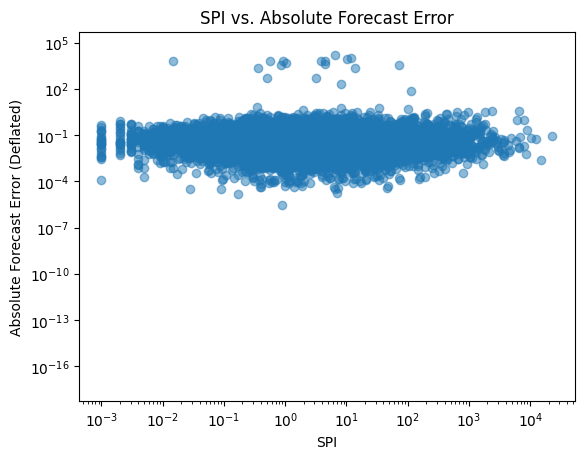

In [60]:
# plot spi vs. absolute forecast error
plt.scatter(df['spi'], df['absolute_forecast_error'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SPI')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('SPI vs. Absolute Forecast Error')
plt.show()

# Income before special items seems to have two clusters

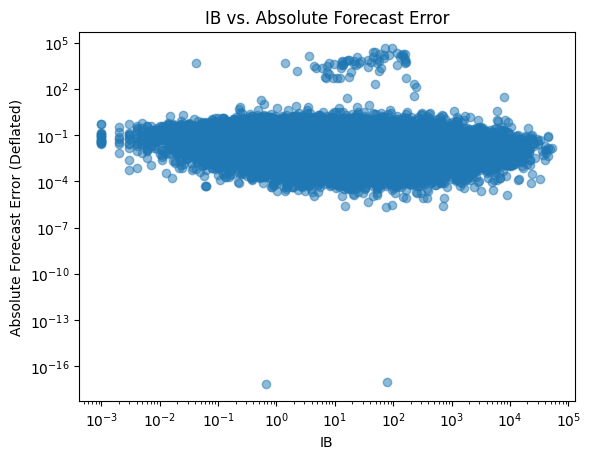

In [61]:
# plot ib vs. absolute forecast error
plt.scatter(df['ib'], df['absolute_forecast_error'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IB')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('IB vs. Absolute Forecast Error')
plt.show()

# Earnings plot once again confirm that there is a cluster with high forecast errors and another one low forecast errors

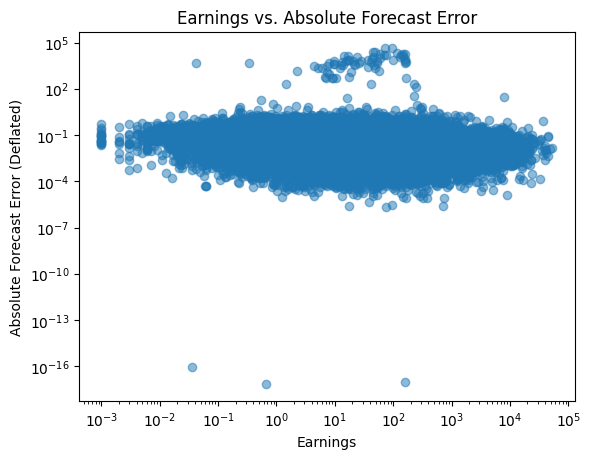

In [62]:
# plot earnings vs. absolute forecast error
plt.scatter(df['E'], df['absolute_forecast_error'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Earnings')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Earnings vs. Absolute Forecast Error')
plt.show()

# Same problem but viewed in another way

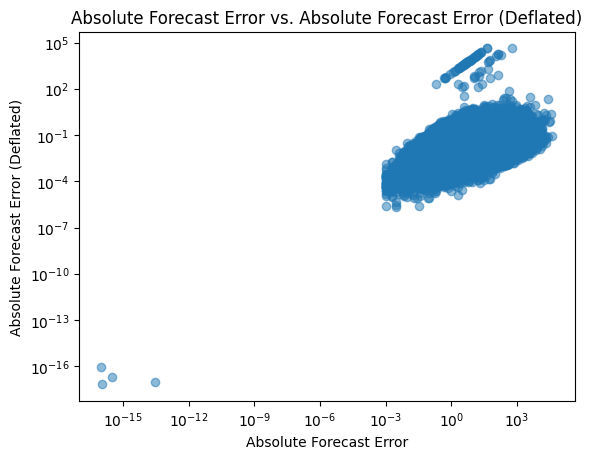

In [63]:
# plot Absolute forecast error vs. Absolute Forecast Error (Deflated)
plt.scatter((df['E_future'] - df['E']).abs(), df['absolute_forecast_error'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Absolute Forecast Error')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Absolute Forecast Error vs. Absolute Forecast Error (Deflated)')
plt.show()

# 2. Impute zero market cap with small constant, 1/99 percentile winsorization on market cap

In [64]:
df['forecast_error_winsorized'] = (df['E_future'] - df['E']) / df['mkt_cap_winsorized']
df['absolute_forecast_error_winsorized'] = df['forecast_error_winsorized'].abs()
df['absolute_forecast_error_winsorized'].describe()

count    126717.000000
mean          0.093285
std           0.994040
min           0.000000
25%           0.011614
50%           0.029668
75%           0.077383
max         283.853153
Name: absolute_forecast_error_winsorized, dtype: float64

# Much closer to the original paper's results!

In [65]:
# 1. Mean Absolute Forecast Error (MAFE)
mafe_winsorized = df['absolute_forecast_error_winsorized'].mean()
print(f"Mean Absolute Forecast Error (MAFE) Winsorized: {mafe_winsorized}")

# 2. Median Absolute Forecast Error
median_afe_winsorized = df['absolute_forecast_error_winsorized'].median()
print(f"Median Absolute Forecast Error Winsorized: {median_afe_winsorized}")

Mean Absolute Forecast Error (MAFE) Winsorized: 0.09328452696685492
Median Absolute Forecast Error Winsorized: 0.02966834212503001


# Idea is to capture the main cluster. If we only concentrate on capturing the main cluster (via winsorization), the results look nice.

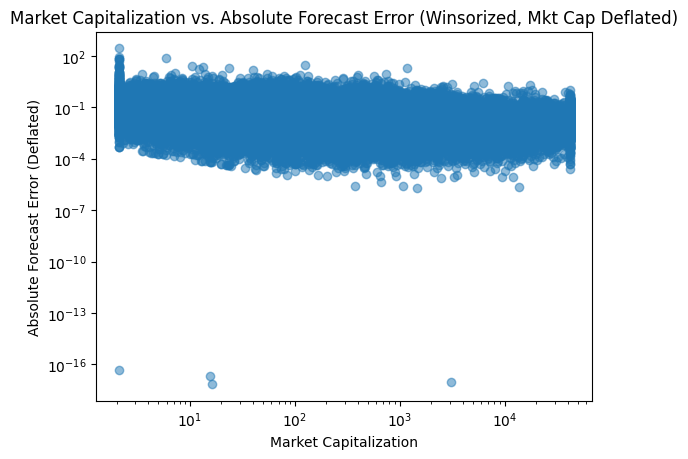

In [66]:
# plot winsorized market cap vs. absolute forecast error (winsorized)
plt.scatter(df['mkt_cap_winsorized'], df['absolute_forecast_error_winsorized'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Market Capitalization')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Market Capitalization vs. Absolute Forecast Error (Winsorized, Mkt Cap Deflated)')
plt.show()

# 3. Filter out observations with zero market cap, no winsorization on market cap

In [67]:
# Create an alternative sample where we delete the rows with zero market capitalization
df_no_zeros = df[df['csho'] != 0]
df_no_zeros['mkt_cap'] = df_no_zeros['csho'] * (df_no_zeros['Pricet'])
df_no_zeros['E_future'] = df_no_zeros.groupby('gvkey')['E'].shift(-1)
df_no_zeros['forecast_error'] = (df_no_zeros['E_future'] - df_no_zeros['E']) / df_no_zeros['mkt_cap']
df_no_zeros['absolute_forecast_error'] = df_no_zeros['forecast_error'].abs()
df_no_zeros['absolute_forecast_error'].describe()

/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_94050/3802635653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_zeros['mkt_cap'] = df_no_zeros['csho'] * (df_no_zeros['Pricet'])
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_94050/3802635653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_zeros['E_future'] = df_no_zeros.groupby('gvkey')['E'].shift(-1)
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_94050/3802635653.py:5: SettingWithCopyWarning: 
A value 

count    126657.000000
mean          1.128676
std         149.961234
min           0.000000
25%           0.011488
50%           0.029498
75%           0.077155
max       41660.280702
Name: absolute_forecast_error, dtype: float64

In [68]:
mafe_no_zeros = df_no_zeros['absolute_forecast_error'].mean()
print(f"Mean Absolute Forecast Error (MAFE) without zero market capitalizations: {mafe_no_zeros}")

# Median Absolute Forecast Error without zero market capitalizations
median_afe_no_zeros = df_no_zeros['absolute_forecast_error'].median()
print(f"Median Absolute Forecast Error without zero market capitalizations: {median_afe_no_zeros}")

Mean Absolute Forecast Error (MAFE) without zero market capitalizations: 1.1286763087869562
Median Absolute Forecast Error without zero market capitalizations: 0.029497518610421828


In [69]:
# Largest forecast errors
top_10_errors_no_zeros = df_no_zeros.nlargest(10, 'absolute_forecast_error')
top_10_errors_no_zeros[['gvkey', 'jdate', 'ib', 'spi', 'E', 'csho', 'Pricet', 'mkt_cap', 'E_future', 'absolute_forecast_error']]

,gvkey,jdate,ib,spi,E,csho,Pricet,mkt_cap,E_future,absolute_forecast_error
105149,4611,1992-03-31,-208.596,-58.901,-149.695,0.001,14.2500,0.014250,443.964,41660.280702
54661,6530,1988-03-31,158.969,0.000,158.969,0.001,8.2500,0.008250,16.634,17252.727273
54664,6530,1991-03-31,-68.166,-25.000,-43.166,0.001,8.2500,0.008250,97.551,17056.606061
146914,7422,2006-03-31,-121.175,-73.716,-47.459,0.001,12.5300,0.012530,138.954,14877.334397
54662,6530,1989-03-31,-54.348,-70.982,16.634,0.001,8.2500,0.008250,-90.159,12944.606061
54660,6530,1987-03-31,-38.858,-140.000,101.142,0.001,8.2500,0.008250,158.969,7009.333333
54659,6530,1986-03-31,156.293,0.000,156.293,0.001,8.2500,0.008250,101.142,6684.969697
54663,6530,1990-03-31,-120.159,-30.000,-90.159,0.001,8.2500,0.008250,-43.166,5696.121212
112457,11669,1994-03-31,-181.003,-158.137,-22.866,0.003,8.6250,0.025875,23.125,1777.429952
107227,14628,2001-03-31,-45.758,0.000,-45.758,0.001,15.8125,0.015813,-68.313,1426.403162


What are these companies? Some top examples:
- SCHOTTENSTEIN STORES CORP
- PACKAGING CORP AMERICA-OLD
- PUERTO RICO TELEPHONE CO
- HANOVER PETROLEUM CORP
- MIDLAND ENTERPRISES INC

# Outlier problem diminished as compare to before, but remember that we got rid of 65 observations because of the filter

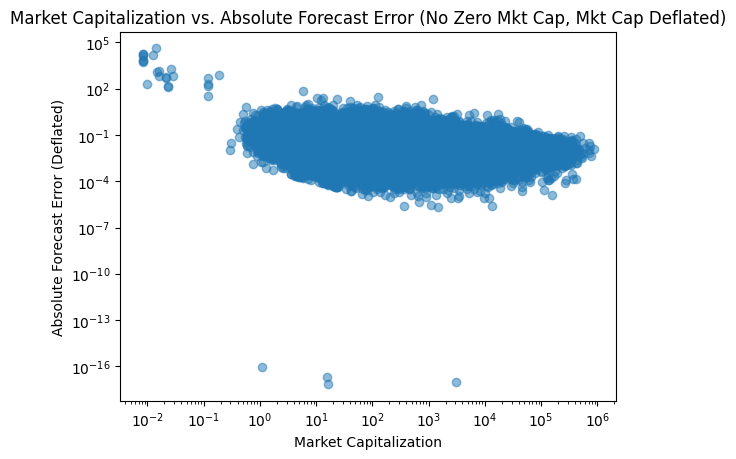

In [70]:
# plot market cap vs. absolute forecast error without zero market capitalizations
plt.scatter(df_no_zeros['mkt_cap'], df_no_zeros['absolute_forecast_error'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Market Capitalization')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Market Capitalization vs. Absolute Forecast Error (No Zero Mkt Cap, Mkt Cap Deflated)')
plt.show()

# 4. Filter out observations with zero market cap, 1/99th percentile winsorization on market cap

In [71]:
df_no_zeros['mkt_cap_winsorized'] = winsorize_series(df_no_zeros['mkt_cap'])
df_no_zeros['forecast_error_winsorized'] = (df_no_zeros['E_future'] - df_no_zeros['E']) / df_no_zeros['mkt_cap_winsorized']
df_no_zeros['absolute_forecast_error_winsorized'] = df_no_zeros['forecast_error_winsorized'].abs()
df_no_zeros['absolute_forecast_error_winsorized'].describe()

/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_94050/2854582604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_zeros['mkt_cap_winsorized'] = winsorize_series(df_no_zeros['mkt_cap'])
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_94050/2854582604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_zeros['forecast_error_winsorized'] = (df_no_zeros['E_future'] - df_no_zeros['E']) / df_no_zeros['mkt_cap_winsorized']
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipyker

count    126657.000000
mean          0.091406
std           0.972162
min           0.000000
25%           0.011606
50%           0.029649
75%           0.077215
max         278.962313
Name: absolute_forecast_error_winsorized, dtype: float64

In [72]:
# 1. Mean Absolute Forecast Error (MAFE) without zero market capitalizations
mafe_no_zeros_winsorized = df_no_zeros['absolute_forecast_error_winsorized'].mean()
print(f"Mean Absolute Forecast Error (MAFE) Winsorized without zero market capitalizations: {mafe_no_zeros_winsorized}")

# 2. Median Absolute Forecast Error without zero market capitalizations
median_afe_no_zeros_winsorized = df_no_zeros['absolute_forecast_error_winsorized'].median()
print(f"Median Absolute Forecast Error Winsorized without zero market capitalizations: {median_afe_no_zeros_winsorized}")

Mean Absolute Forecast Error (MAFE) Winsorized without zero market capitalizations: 0.0914061449305322
Median Absolute Forecast Error Winsorized without zero market capitalizations: 0.029649376992176183


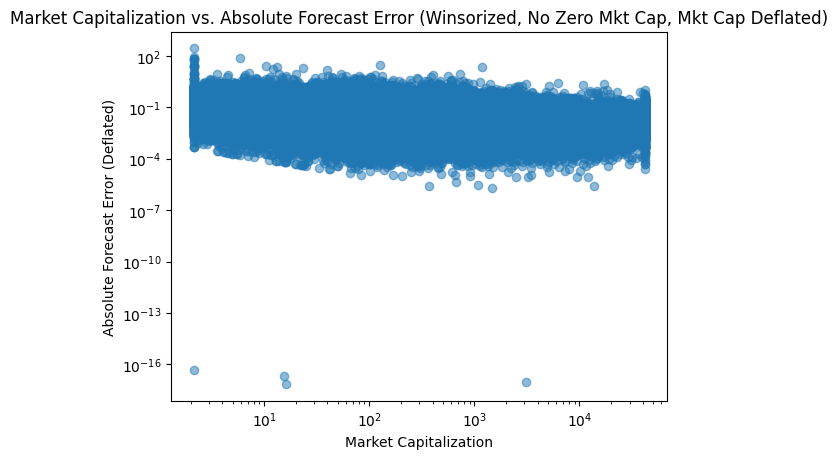

In [73]:
# plot winsorized market cap vs. absolute forecast error (winsorized) without zero market capitalizations
plt.scatter(df_no_zeros['mkt_cap_winsorized'], df_no_zeros['absolute_forecast_error_winsorized'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Market Capitalization')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Market Capitalization vs. Absolute Forecast Error (Winsorized, No Zero Mkt Cap, Mkt Cap Deflated)')
plt.show()

# 5. Use shrout to calculate market cap, no winsorization

In [80]:
df['mkt_cap_alt'] = df['Shrout_at_Pricet'] * df['Pricet']

df['forecast_error_alt'] = (df['E_future'] - df['E']) / df['mkt_cap_alt']
df['absolute_forecast_error_alt'] = df['forecast_error_alt'].abs()
df['absolute_forecast_error_alt'].describe()

count    126717.000000
mean          0.087088
std           0.288416
min           0.000000
25%           0.011396
50%           0.029063
75%           0.077161
max          25.582094
Name: absolute_forecast_error_alt, dtype: float64

In [81]:
# 1. Mean Absolute Forecast Error (MAFE) with alternative market capitalization
mafe_alt = df['absolute_forecast_error_alt'].mean()
print(f"Mean Absolute Forecast Error (MAFE) with alternative market capitalization: {mafe_alt}")

# 2. Median Absolute Forecast Error with alternative market capitalization
median_afe_alt = df['absolute_forecast_error_alt'].median()
print(f"Median Absolute Forecast Error with alternative market capitalization: {median_afe_alt}")

Mean Absolute Forecast Error (MAFE) with alternative market capitalization: 0.08708752879990116
Median Absolute Forecast Error with alternative market capitalization: 0.029063107325427006


In [82]:
# Largest forecast errors with alternative market capitalization
top_10_errors_alt = df.nlargest(10, 'absolute_forecast_error_alt')
top_10_errors_alt[['gvkey', 'jdate', 'ib', 'spi', 'E', 'csho', 'Pricet', 'mkt_cap_alt', 'E_future', 'absolute_forecast_error_alt']]

,gvkey,jdate,ib,spi,E,csho,Pricet,mkt_cap_alt,E_future,absolute_forecast_error_alt
21101,8964,2001-03-31,-7058.978,-6760.000,-298.978,3.519,2.95000,10.381050,-33.409,25.582094
21100,8964,2000-03-31,16.364,0.000,16.364,3.481,3.81250,13.271312,-298.978,23.761177
9727,5073,2009-03-31,-30860.000,-11808.000,-19052.000,610.483,1.94000,1184.373880,6443.000,21.526142
117811,15060,2009-03-31,-438.893,-11.871,-427.022,21.621,1.09000,23.584330,57.941,20.562933
16139,8210,2016-03-31,283.960,-41.199,325.159,372.049,2.15000,15.996000,30.491,18.421355
66656,6788,1984-03-31,0.546,0.000,0.546,9.981,1.21875,12.164344,219.921,18.034265
114913,29755,2009-03-31,-951.248,-52.470,-898.778,39.270,1.01000,39.646540,-290.375,15.345677
123507,14292,1996-03-31,-38.863,-12.273,-26.590,3.243,2.00000,2.432000,7.225,13.904194
16138,8210,2015-03-31,-152.273,-191.920,39.647,315.762,4.10000,23.259300,325.159,12.275176
10493,14895,2001-03-31,-190.725,-59.969,-130.756,80.309,1.18750,9.536812,-15.252,12.111384


# Best Result, with no winsorization!

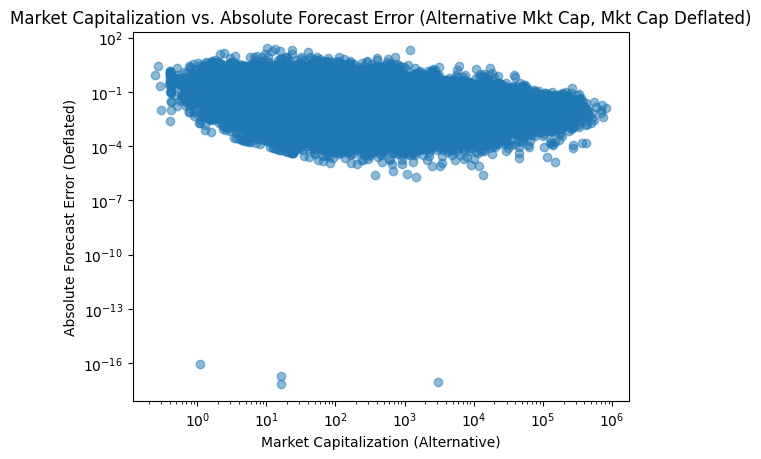

In [83]:
# plot market cap vs. absolute forecast error with alternative market capitalization
plt.scatter(df['mkt_cap_alt'], df['absolute_forecast_error_alt'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Market Capitalization (Alternative)')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Market Capitalization vs. Absolute Forecast Error (Alternative Mkt Cap, Mkt Cap Deflated)')
plt.show()

## Alternative specifications (Robustness checks) using approach 2

### Forecast errors deflated by total assets

In [86]:
df['at'] = df['at'].replace(0, 1e-6)
df['at_winsorized'] = winsorize_series(df['at'])

# Forecast error: future earnings minus the current earnings divided by the total assets
df['forecast_error_alt'] = (df['E_future'] - df['E']) / df['at_winsorized']
df['absolute_forecast_error_alt'] = df['forecast_error_alt'].abs()
df['absolute_forecast_error_alt'].describe()

count    126717.000000
mean          0.065409
std           0.180395
min           0.000000
25%           0.011518
50%           0.027447
75%           0.064319
max          30.534061
Name: absolute_forecast_error_alt, dtype: float64

In [87]:
# 1. Mean Absolute Forecast Error (MAFE)
mafe = df['absolute_forecast_error_alt'].mean()
print(f"Mean Absolute Forecast Error (MAFE): {mafe}")
print(f"Expected: 0.0593")

# 2. Median Absolute Forecast Error
median_afe = df['absolute_forecast_error_alt'].median()
print(f"Median Absolute Forecast Error: {median_afe}")

Mean Absolute Forecast Error (MAFE): 0.06540855858896584
Expected: 0.0593
Median Absolute Forecast Error: 0.02744731997485483


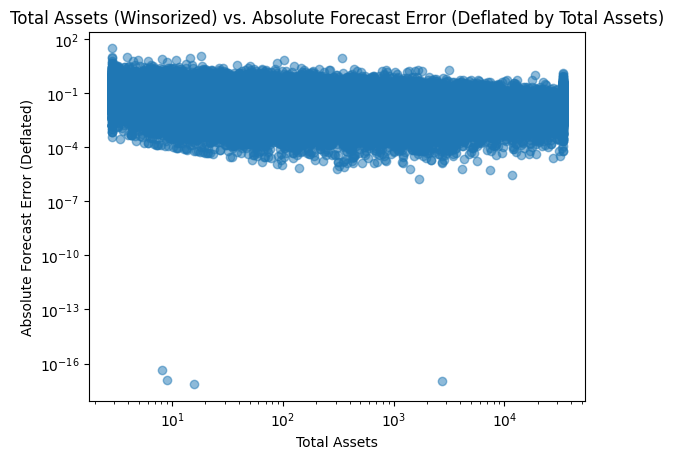

In [76]:
# plot total asset vs. absolute forecast error
plt.scatter(df['at_winsorized'], df['absolute_forecast_error_alt'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Assets')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Total Assets (Winsorized) vs. Absolute Forecast Error (Deflated by Total Assets)')
plt.show()

### Per share forecast errors

In [90]:
df['csho'] = df['csho'].replace(0, 1e-6)
df['csho_winsorized'] = winsorize_series(df['csho'])

# Forecast error: future earnings minus the current earnings divided by the total assets
df['forecast_error_alt2'] = (df['E_future'] - df['E']) / df['csho_winsorized']
df['absolute_forecast_error_alt2'] = df['forecast_error_alt2'].abs()
df['absolute_forecast_error_alt2'].describe()

count    126717.000000
mean          1.054298
std          22.949628
min           0.000000
25%           0.156545
50%           0.385281
75%           0.859123
max        5309.431525
Name: absolute_forecast_error_alt2, dtype: float64

In [91]:
# 1. Mean Absolute Forecast Error (MAFE)
mafe = df['absolute_forecast_error_alt2'].mean()
print(f"Mean Absolute Forecast Error (MAFE): {mafe}")
print(f"Expected: 0.7378")

# 2. Median Absolute Forecast Error
median_afe = df['absolute_forecast_error_alt2'].median()
print(f"Median Absolute Forecast Error: {median_afe}")

Mean Absolute Forecast Error (MAFE): 1.0542981562816003
Expected: 0.7378
Median Absolute Forecast Error: 0.38528138528138534


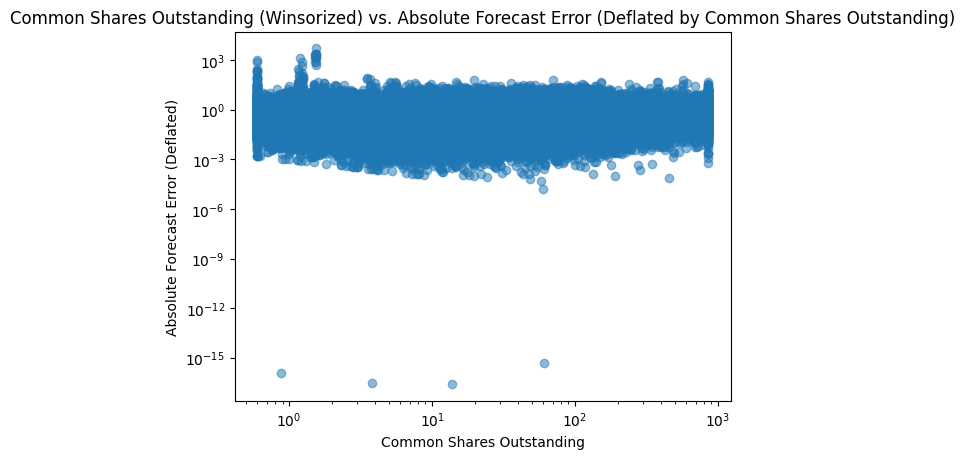

In [92]:
# plot common shares outstanding vs. absolute forecast error
plt.scatter(df['csho_winsorized'], df['absolute_forecast_error_alt2'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Common Shares Outstanding')
plt.ylabel('Absolute Forecast Error (Deflated)')
plt.title('Common Shares Outstanding (Winsorized) vs. Absolute Forecast Error (Deflated by Common Shares Outstanding)')
plt.show()